In [1]:
import sys
sys.path.append("../bliss/build/bliss/python")
import blissdedrift


Found a usable device
Found a usable device
Found a usable device
Found a usable device


<frozen importlib._bootstrap>:241: RuntimeWarning: nanobind: type 'ndarray' was already registered!

<frozen importlib._bootstrap>:241: RuntimeWarning: nanobind: type 'dev' was already registered!

<frozen importlib._bootstrap>:241: RuntimeWarning: nanobind: type 'datatype' was already registered!



WARN: plot_utils could not import `altair`. `scatter_matrix_hits` will not be available


In [2]:
blissdedrift._cuda_version

'11.7'

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# filpath = "/datax/scratch/nwest/voltage-gen/fbh5/t1/singlecoarse_fwhm=48.0_injected_f=6003329687.5_snr=1000_drift=3.4.rawspec.0000.h5"
filpath = "/datag/public/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"
filpath = "just_noise_chisq_4dof.h5"
filpath = "just_noise_chisq_204dof.h5"
# filpath = "/datax/scratch/nwest/voltage-gen/constquant/fbh5/t1/singlecoarse-fwhm_48.0-injected_f_6003329687.5-snr_1000.0-drift_3.4.rawspec.0000.h5"


In [30]:
!ls -ltah $filpath

-rw-rw-r-- 1 nwest nwest 65M Oct  4 10:27 just_noise_chisq_204dof.h5


In [31]:
import h5py

In [32]:
fbh5 = h5py.File(filpath)


In [33]:


pipeline_obj = blissdedrift.scan(filpath, 1048576)

# pipeline_obj = blissdedrift.preprocess.normalize(pipeline_obj)
# pipeline_obj = blissdedrift.preprocess.equalize_passband_filter(pipeline_obj, "../bliss/build/channelizer_response.f32")

pipeline_obj.set_device("cuda:1")
# pipeline_obj.set_device("cpu")


# pipeline_obj = blissdedrift.flaggers.flag_filter_rolloff(pipeline_obj, .25)

pipeline_obj = blissdedrift.flaggers.flag_spectral_kurtosis(pipeline_obj, .1, 25)
pipeline_obj = blissdedrift.flaggers.flag_sigmaclip(pipeline_obj, 15, 5, 6)

noise_est_options = blissdedrift.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = True
noise_est_options.estimator_method = blissdedrift.estimators.noise_power_estimator.stddev
pipeline_obj = blissdedrift.estimators.estimate_noise_power(pipeline_obj, noise_est_options)


opts = blissdedrift.integrate_drifts_options()
opts.desmear = True
opts.low_rate = -200
opts.high_rate = 500
opts.rate_step_size = 1

# pipeline_obj = blissdedrift.drift_search.integrate_drifts(pipeline_obj, opts)

# hit_search_opts = blissdedrift.drift_search.hit_search_options()
# hit_search_opts.method = blissdedrift.drift_search.hit_search_methods.connected_components
# hit_search_opts.snr_threshold = 10.0

# pipeline_obj_with_hits = blissdedrift.drift_search.hit_search(pipeline_obj, hit_search_opts)


# pipeline_obj_with_hits.set_device("cpu")


# for h in pipeline_obj_with_hits.hits():
#     print(h)


INFO: HDF5 looking for filter plugins in: 
	'/usr/lib/x86_64-linux-gnu/hdf5/serial/plugin '
INFO: h5_filterbank_file: mask is not in this file. This is recoverable.
INFO: using cuda:1 :: NVIDIA RTX A4000 (UUID: d2c9316d9bdf6bfaf7bac661a338ae78)


In [34]:

cc = pipeline_obj.read_coarse_channel(0)

noise_est = cc.noise_estimate

print(noise_est.noise_power)
print(noise_est.noise_floor)


20.198951721191406
204.00538635253906
INFO: spec kurtosis with M=16 and N=51


In [35]:
data = np.from_dlpack(cc.data.to("cpu"))

print(f"data slice mean: {np.mean(data[:,300000:500000])}")
print(f"data slice std: {np.std(data[:,300000:500000])}")

print(f"data  mean: {np.mean(data[:,:])}")
print(f"data  std: {np.std(data[:,:])}")


data slice mean: 203.99940490722656
data slice std: 20.208127975463867
data  mean: 204.00534057617188
data  std: 20.199111938476562


: 

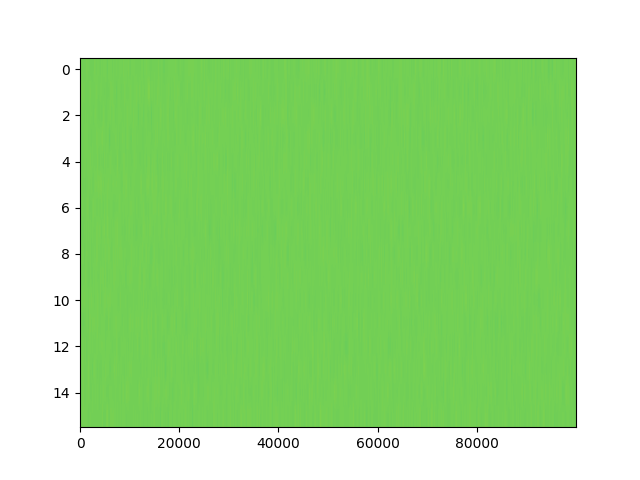

In [11]:

plt.figure()
plt.imshow(np.log10(data[:,300000:400000]), aspect="auto")


Text(0.5, 0, 'Time along dynamic spectra')

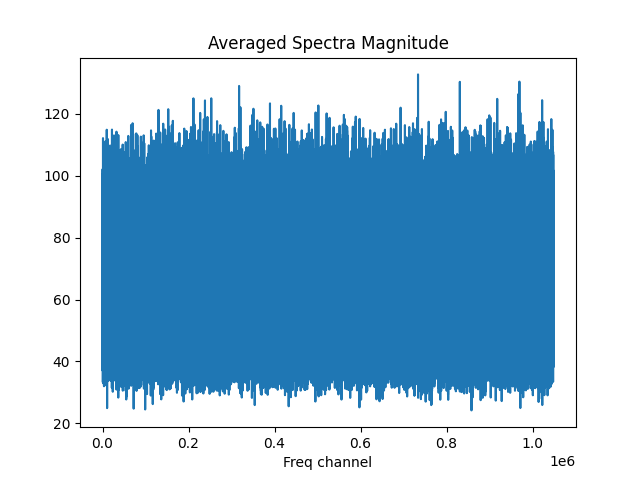

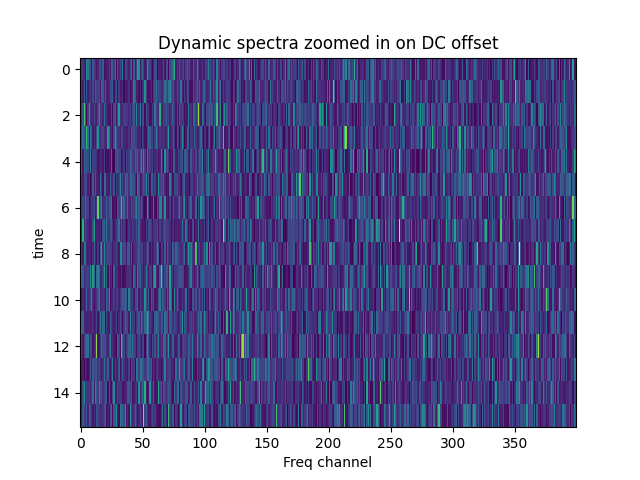

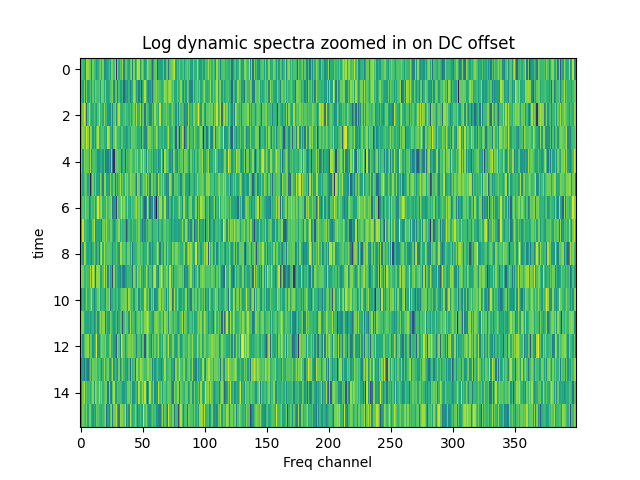

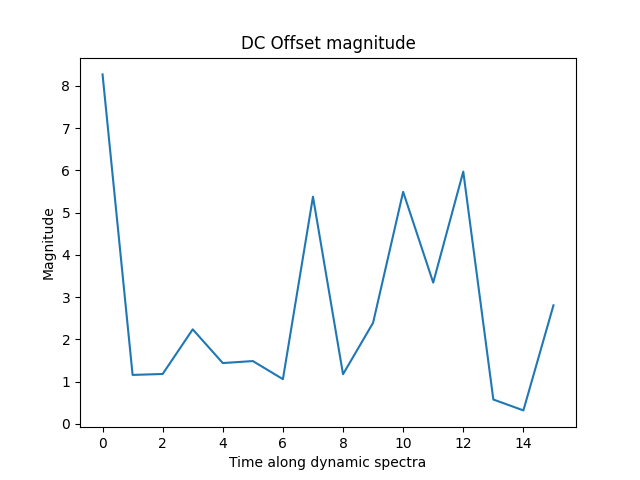

In [12]:
plt.figure()
plt.plot(data.sum(0))
plt.title("Averaged Spectra Magnitude")
plt.xlabel("Freq channel")
plt.figure()
plt.imshow(data[:,524288-200:524288+200], aspect="auto", interpolation="none")
plt.title("Dynamic spectra zoomed in on DC offset")
plt.ylabel("time")
plt.xlabel("Freq channel")
plt.figure()
plt.imshow(10*np.log10(data[:,524288-200:524288+200]), aspect="auto", interpolation="none")
plt.title("Log dynamic spectra zoomed in on DC offset")
plt.ylabel("time")
plt.xlabel("Freq channel")

plt.figure()
plt.plot(data[:,int(2**20//2)])
plt.title("DC Offset magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time along dynamic spectra")


In [13]:
2**20/2


524288.0

In [14]:
import numpy as np

In [15]:
mask = cc.mask.to("cpu")
mask_np = np.from_dlpack(mask)

data = cc.data.to("cpu")
data_np = np.from_dlpack(data)


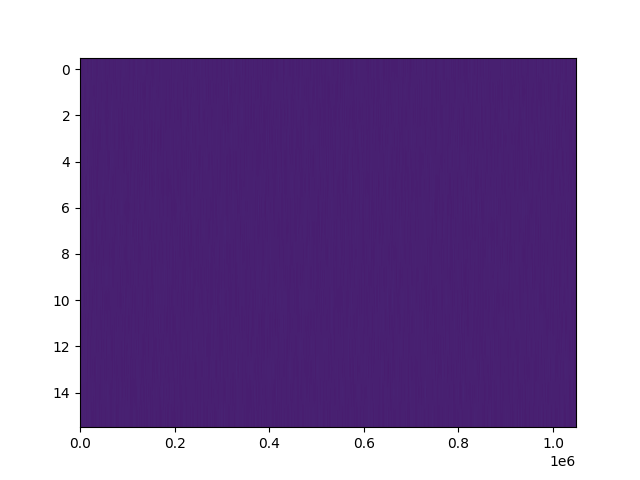

In [16]:
plt.figure()
plt.imshow(data_np, aspect="auto")
# plt.plot(data_np.sum(0))


Text(0.5, 0, 'Freq channel')

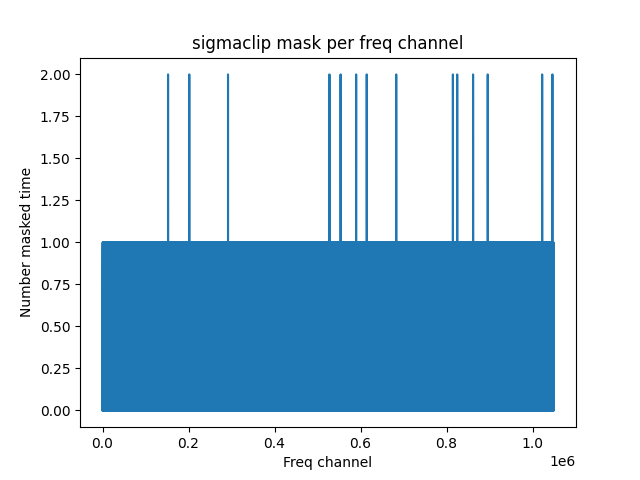

In [17]:
plt.figure()
plt.plot((mask_np & 32).sum(0)/32)
plt.title("sigmaclip mask per freq channel")
plt.ylabel("Number masked time")
plt.xlabel("Freq channel")

In [18]:

sk = blissdedrift.pybliss.estimators.estimate_spectral_kurtosis(cc, d=2)



INFO: spec kurtosis with M=16 and N=1


In [19]:

sk_np = np.from_dlpack(sk.to("cpu"))


Text(0.5, 0, 'Frequency channel')

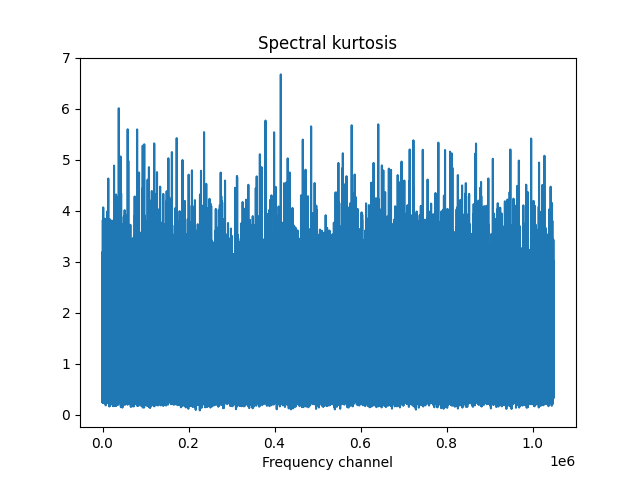

In [20]:
plt.figure()
plt.plot(sk_np)
plt.title("Spectral kurtosis")
plt.xlabel("Frequency channel")


In [21]:
np.mean(sk_np[200000:400000])

np.float32(1.0003778)

In [22]:
np.mean(sk_np[200000:400000])

np.float32(1.0003778)

In [23]:
noise_slice = np.from_dlpack(data)[:,200000:400000]

In [24]:
noise_slice.shape

(16, 200000)

In [25]:
s1 = np.square(np.sum(noise_slice, 0))
s2 = np.sum(np.square(noise_slice), 0)

M = 16
N = 51
d = 2

sk = ((M * N * d + 1) / (M-1)) * (M * (s2/s1) -1)


In [26]:
np.mean(sk)

np.float32(49.50354)